Simulation for branching process with random mutation. Each time the pathogen transmits to a new person, it mutates. 

IN THIS VERSION, BOTH BETA AND GAMMA ARE ALLOWED TO MUTATE.

There are 2 functions, "sim" and "recurrent_sim".

"sim" represents a process without recurrent spillover. It seeds the population with an initial case (presumably spilled over from a reservoir). It branches until either the infection goes extinct, or it surpasses a threshold. In the latter case, we call it an outbreak. 

"recurrent_sim" represents a process with random recurrent spillover, at some rate alpha. It begins with a single founding spillover case. Then it branches until either the infection goes extinct, or surpasses a threshold. In the process with recurrent spillover, extinction is defined as any moment in time when there are 0 infected people. (Note this is not stable, as eventually a new spillover will occur).

Possible to dos: 
    1. Make more graphs/visualizations.
    2. Include backwards transmission.
    3. Try it with a finite population.
    4. Check the implementation of interevent time against the results in Linda's talk.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as sm

Simulations WITHOUT Recurrent Spillover

In [20]:
###################################################
# simulates infection WITHOUT recurrent spillover #
# ALLOWS BOTH BETA AND GAMMA TO MUTATE.           #
###################################################
#
# input beta0 is transmission rate of the initial case.
# input gamma0 is recovery rate of the initial case. 
#
# optional input mu1 represents mutation rate for beta. If unspecified, defaults to 0.001
# optional input mu2 represents mutation rate for gamma. If unspecified, defaults to 0.001
#
###################################################
#
# returns [0, t_ext] if extinction, where t is time of extinction. 
# returns [1] if outbreak
#
###################################################
def sim(beta_0, gamma_0, mu_1=0.001, mu_2=0.001):
    
    outbreak_thresh = 100 #call it an outbreak if this many people are infected
    
    #contains active cases as an array of triples
    #in each triple 1st elt is beta, 2nd elt is gamma, and 3rd elt is time infected
    infecteds=[[beta_0, gamma_0, 0]] 
    
    N_infected = len(infecteds) #keeps track of number of infected people
    
    t_ext = None #time of extinction, will fill this value and return it
    
    while True: 
        
        #print("\n", "infecteds now = ", infecteds)
        
        recovereds = [] #keep track of indices of recovered people
        
        for i, x in enumerate(infecteds): #i is index, x is value
            
            beta = x[0]
            gamma = x[1]
            t = x[2]

            #print("\n", "branching person", i)
            
            while True:
                
                #interevent time (??)
                #note this is interevent time for ONE person, NOT for entire population
                dt = np.random.exponential(scale=1/(beta + gamma))
                new_t = t + dt #time of new event
                
                #pick which new event, transmission or recovery, happens            
                ev = np.random.rand() #draw number from uniform distribution over [0, 1)
                prob_trans = beta / (beta+gamma) #probability of transmission instead of recovery

                if (ev < prob_trans): #transmission
                    
                    #print("person", i, " is transmitting")
                    
                    N_infected += 1
                    
                    #pick beta for new case
                    mut1 = np.random.normal(loc=0.0, scale=mu_1) #mutation is a number drawn from normal distribution
                    new_beta = max(0, beta + mut1) #don't allow negative beta
                    
                    #pick gamma for new case
                    mut2 = np.random.normal(loc=0.0, scale=mu_2) #mutation is a number drawn from normal distribution
                    new_gamma = max(0, gamma + mut2) #don't allow negative gamma
                    
                    infecteds = np.append(infecteds, [[new_beta, new_gamma, new_t]], axis=0)
                    #print("new infection: ", [new_beta, new_gamma, new_t])

                else: #recovery
                    
                    #print("person", i, " recovers") 
                    
                    N_infected -= 1
                    
                    if N_infected == 0:
                        t_ext = new_t #time of extinction
                    
                    recovereds.append(i) #mark index of this recovered person
                    break #skip to next person

        #after each time we complete a round of branching everybody:
        #1. update the list of infecteds by deleting recovered people
        #2. and check if we have extinction/outbreak yet
        
        infecteds = np.delete(infecteds, recovereds, axis=0)
        
        if N_infected == 0:
            #print("\n", "extinction")
            return [0, t_ext]
        elif N_infected >= outbreak_thresh:
            #print("\n", "outbreak!")
            return [1]

In [21]:
#####################################################
# runs many simulations WITHOUT recurrent spillover #
#####################################################
#
# returns the percentage of simulations that outbreak
#
#####################################################

def sim_percentage(beta_0, gamma_0, mu_1=0.001, mu_2=0.001):
    
    N_sims = 1000 #number of simulations
    
    N_outbreaks = 0
    for i in range(N_sims):
        if sim(beta_0, gamma_0, mu_1, mu_2) == [1]: N_outbreaks += 1
    return N_outbreaks/N_sims

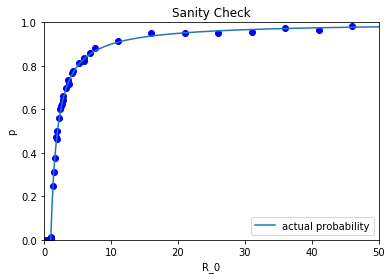

In [23]:
################
# SANITY CHECK #
################
#
# When there is no mutation, check that our simulation agrees with known results.
# From Linda's talk: the correct probability of outbreak is:
#
#                            0 if R_0 < 1
#                            1-1/R_0 = 1-gamma/beta if R_0 > 1
#
################

#Take a grid of gamma and beta values, which correspond to a variety of R_0 values.
beta_range = np.arange(0.1, 5, 0.5)
gamma_range = np.arange(0.1, 2, 0.5)

#plot simulated percentages of outbreak
for beta in beta_range:
    for gamma in gamma_range:
        R_0 = beta/gamma
        p = sim_percentage(beta, gamma, mu_1=0, mu_2=0) #mutation rates are set to 0
        plt.plot(R_0, p, "ob")


#plot actual probabilities of outbreak
R_0 = np.arange(0.01,50,0.1)
plt.plot(R_0, 1-1/R_0, label='actual probability')

plt.title('Sanity Check')
plt.xlabel("R_0")
plt.ylabel("p")
plt.xlim(0, 50)
plt.ylim(0,1)
plt.legend()
plt.show()

Simulations WITH Recurrent Spillover

In [211]:
################################################
# simulates infection WITH recurrent spillover #
################################################
#
# input alpha = spillover rate. 
#
# returns 1 if outbreak
# returns 0 if extinction
#
################################################
#
# hidden inputs, ONLY for use by this function when it recursively calls itself.
# (do NOT need to pass in these inputs when manually calling the function)
#
# hidden input max_t_ext keeps track of maximum extinction time seen so far
# hidden input t_s keeps track of time of last spillover
#
################################################

def recurrent_sim(alpha, beta_0, gamma_0, mu_1=0.001, mu_2=0.001, max_t_ext=0, t_s=0): 
    #print("max_t_ext = ", max_t_ext)
    
    sim_output = sim(beta_0, gamma_0, mu_1, mu_2)

    #if simulation outbreaks, we are done
    if sim_output == [1]:
        
        #print("\n", "outbreak!")
        return 1
    
    else:
        #print("max_t_ext updating, = max of ", max_t_ext, "and", sim_output[1])
        max_t_ext = max(max_t_ext, sim_output[1]) #update max extinction time, if necessary
        
        #generate the time of the next spillover event
        dt_s = np.random.exponential(scale=1/alpha) #interevent time  
        #print("drawing dt_s = ", dt_s)
        t_s += dt_s #actual time of spillover
        #print("actual time of spillover is t_s = ", t_s)

        # if spillover occurs soon enough, recurse
        if t_s < max_t_ext: 
            #print("a spillover occured! Running another simulation...")
            return recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2, max_t_ext, t_s)

        # if spillover occurs too late, return 0
        else: 
            #print("next spillover too late. extinction!")
            return 0

In [212]:
####################################################
# run a single simulation WITH recurrent spillover #
####################################################

#parameters
alpha = 0.1
beta_0 = 0.09
gamma_0 = 0.1

recurrent_sim(alpha, beta_0, gamma_0)

0

In [213]:
##################################################
# runs many simulations WITH recurrent spillover #
##################################################
#
# returns the percentage of them that outbreak
#
##################################################

def recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1 = 0.01, mu_2 = 0.01): 
    
    N_sims = 10 #number of simulations
    
    N_outbreaks = 0
    for i in range(N_sims):
        if recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2) == 1: 
                N_outbreaks += 1
    return N_outbreaks/N_sims

In [290]:
#########################################################
# run a single bulk simulation WITH recurrent spillover #
#########################################################

#parameters
alpha = 0.7
beta_0 = 0.09
gamma_0 = 0.1

recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1=0.001, mu_2=0.001)

0.2